## Analyzing Research Articles using Topic Modelling Approach


In [40]:
#Importing neccessary libraries

import pandas as pd
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


In [41]:
# Load and read datasets

papers = pd.read_excel('C:/Users/Saleeh/Documents/Salford University/Lectures/AI - Natural Language Processing/Assessment/Dataset/Scopus Extract/Scopus dataset.xlsx')

In [42]:
# View first 5 rows of data 

papers.head()

,Authors,Title,Year,Source title,Link,Abstract,Author Keywords,Subject
0,Belguith S.; Kaaniche N.; Laurent M.; Jemai A....,Accountable privacy preserving attribute based...,2020,Journal of Parallel and Distributed Computing,https://www.scopus.com/inward/record.uri?eid=2...,"In this paper, we propose an accountable priva...",Accountability; Attribute based encryption; At...,Mathematics
1,Kumaran G.; Sivaraj R.; Ramachandra Prasad V.;...,Finite difference computation of free magneto-...,2021,Physica Scripta,https://www.scopus.com/inward/record.uri?eid=2...,It is essential to account the variability in ...,Chemical reaction; Keller box method; Powell-e...,Mathematics
2,Zahedi E.; Saraee M.; Masoumi F.S.; Yazdinejad M.,Regularized Contrastive Masked Autoencoder Mod...,2023,Algorithms,https://www.scopus.com/inward/record.uri?eid=2...,"Unsupervised anomalous sound detection, especi...",anomalous sound detection; Contrastive learnin...,Mathematics
3,Oladipupo M.A.; Obuzor P.C.; Bamgbade B.J.; Ol...,An Automated Python Script for Data Cleaning a...,2023,Informatica (Slovenia),https://www.scopus.com/inward/record.uri?eid=2...,Every employee in the company who deals with d...,automation; data cleaning; financial dataset; ...,Mathematics
4,Roy A.K.; Debnath S.; Bég O.A.,Transient solute dispersion in electro-osmotic...,2023,ZAMM Zeitschrift fur Angewandte Mathematik und...,https://www.scopus.com/inward/record.uri?eid=2...,The transport of a neutral solute in incompres...,NaN,Mathematics


In [43]:
papers.describe(include = 'all')

,Authors,Title,Year,Source title,Link,Abstract,Author Keywords,Subject
count,1142,1142,1142.000000,1142,1142,1142,1026,1142
unique,998,1040,NaN,613,1040,1026,931,5
top,Lomas D.W.B.,Dynamic modeling and characterization of compl...,NaN,Journal of Strength and Conditioning Research,https://www.scopus.com/inward/record.uri?eid=2...,[No abstract available],cable vibration; cable-driven parallel robot; ...,Medicine
freq,4,3,NaN,27,3,15,3,385
mean,NaN,NaN,2022.069177,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,1.366795,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2019.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2022.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2022.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2023.000000,NaN,NaN,NaN,NaN,NaN


Datasets has different number of unique values for title and abstract and total number of records indicating that some documents may have similar titles or abstracts across different subject classes.

In [44]:
# summary of the columns in the dataset
# Totals rows of that is 303

papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Authors          1142 non-null   object
 1   Title            1142 non-null   object
 2   Year             1142 non-null   int64 
 3   Source title     1142 non-null   object
 4   Link             1142 non-null   object
 5   Abstract         1142 non-null   object
 6   Author Keywords  1026 non-null   object
 7   Subject          1142 non-null   object
dtypes: int64(1), object(7)
memory usage: 71.5+ KB


In [45]:
# Remove columns that does not relate to the task and select chunck of the data (sample >> 100)
# Add paper_text column

papers = papers.drop(columns=['Authors','Source title','Link','Subject'], axis=1).sample(100)

#print out the first five rows of papers
papers.head()

,Title,Year,Abstract,Author Keywords
214,On the limitations of transmissibility functio...,2024,Transmissibility functions are used to identif...,completeness; Damage localisation; output-only...
560,Task-shifting for point-of-care cervical cance...,2023,Cervical cancer remains the leading cause of f...,cervical cancer; frugal innovation; geographic...
217,Semi-active control of independently rotating ...,2024,This paper presents an in-depth analysis of st...,independently rotating wheelset; Passive and s...
100,Numerical study of viscoelastic micropolar hea...,2019,A mathematical model is developed to study lam...,Boundary layers; Deborah number; Eringen micro...
722,UK survey demonstrates a wide range of impacts...,2022,Objective: To understand the impact of the UK ...,clinical; embedded; evidence-based library and...


In [46]:
# Add paper_text column
papers['paper_text'] = papers['Title'] + " " + papers['Abstract']

#print out the first five rows of papers
papers.head()

,Title,Year,Abstract,Author Keywords,paper_text
214,On the limitations of transmissibility functio...,2024,Transmissibility functions are used to identif...,completeness; Damage localisation; output-only...,On the limitations of transmissibility functio...
560,Task-shifting for point-of-care cervical cance...,2023,Cervical cancer remains the leading cause of f...,cervical cancer; frugal innovation; geographic...,Task-shifting for point-of-care cervical cance...
217,Semi-active control of independently rotating ...,2024,This paper presents an in-depth analysis of st...,independently rotating wheelset; Passive and s...,Semi-active control of independently rotating ...
100,Numerical study of viscoelastic micropolar hea...,2019,A mathematical model is developed to study lam...,Boundary layers; Deborah number; Eringen micro...,Numerical study of viscoelastic micropolar hea...
722,UK survey demonstrates a wide range of impacts...,2022,Objective: To understand the impact of the UK ...,clinical; embedded; evidence-based library and...,UK survey demonstrates a wide range of impacts...


In [47]:
# Remove missing values

papers = papers.dropna(axis='rows')

papers.head()

,Title,Year,Abstract,Author Keywords,paper_text
214,On the limitations of transmissibility functio...,2024,Transmissibility functions are used to identif...,completeness; Damage localisation; output-only...,On the limitations of transmissibility functio...
560,Task-shifting for point-of-care cervical cance...,2023,Cervical cancer remains the leading cause of f...,cervical cancer; frugal innovation; geographic...,Task-shifting for point-of-care cervical cance...
217,Semi-active control of independently rotating ...,2024,This paper presents an in-depth analysis of st...,independently rotating wheelset; Passive and s...,Semi-active control of independently rotating ...
100,Numerical study of viscoelastic micropolar hea...,2019,A mathematical model is developed to study lam...,Boundary layers; Deborah number; Eringen micro...,Numerical study of viscoelastic micropolar hea...
722,UK survey demonstrates a wide range of impacts...,2022,Objective: To understand the impact of the UK ...,clinical; embedded; evidence-based library and...,UK survey demonstrates a wide range of impacts...


# Text Preprocessing

The Text preprocessing step will be carried out in the following step

1. Data Cleaning
2. Tokenization
3. Stopword Removal
4. Normalization
5. Text Encoding
6. Vectorization
7. Data Splitting

In [48]:
#Import neccessary libraries for text preprocessing

import re
from string import punctuation
import contractions

In [49]:
#Create a function for preprocessing

def clean_text(text):
    # make text lowercase    
    text = str(text).lower()
    # expand contractions
    text = " ".join([contractions.fix(expanded_word) for expanded_word in text.split()])
    # remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(punctuation), '', text)
    # remove new lines
    text = re.sub('\n', '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # remove apostrophes
    text = re.sub("''", '', text)
    return text

In [50]:
# apply function on each text in the dataset

papers['paper_text_preprocessed'] = papers['paper_text'].apply(lambda x: clean_text(x))

papers.head()

,Title,Year,Abstract,Author Keywords,paper_text,paper_text_preprocessed
214,On the limitations of transmissibility functio...,2024,Transmissibility functions are used to identif...,completeness; Damage localisation; output-only...,On the limitations of transmissibility functio...,on the limitations of transmissibility functio...
560,Task-shifting for point-of-care cervical cance...,2023,Cervical cancer remains the leading cause of f...,cervical cancer; frugal innovation; geographic...,Task-shifting for point-of-care cervical cance...,taskshifting for pointofcare cervical cancer p...
217,Semi-active control of independently rotating ...,2024,This paper presents an in-depth analysis of st...,independently rotating wheelset; Passive and s...,Semi-active control of independently rotating ...,semiactive control of independently rotating w...
100,Numerical study of viscoelastic micropolar hea...,2019,A mathematical model is developed to study lam...,Boundary layers; Deborah number; Eringen micro...,Numerical study of viscoelastic micropolar hea...,numerical study of viscoelastic micropolar hea...
722,UK survey demonstrates a wide range of impacts...,2022,Objective: To understand the impact of the UK ...,clinical; embedded; evidence-based library and...,UK survey demonstrates a wide range of impacts...,uk survey demonstrates a wide range of impacts...


### Tokenization

In [51]:
### Add comment

from nltk.tokenize import word_tokenize
papers['paper_words'] = papers['paper_text_preprocessed'].apply(lambda x:word_tokenize(str(x)))
papers.head()

,Title,Year,Abstract,Author Keywords,paper_text,paper_text_preprocessed,paper_words
214,On the limitations of transmissibility functio...,2024,Transmissibility functions are used to identif...,completeness; Damage localisation; output-only...,On the limitations of transmissibility functio...,on the limitations of transmissibility functio...,"[on, the, limitations, of, transmissibility, f..."
560,Task-shifting for point-of-care cervical cance...,2023,Cervical cancer remains the leading cause of f...,cervical cancer; frugal innovation; geographic...,Task-shifting for point-of-care cervical cance...,taskshifting for pointofcare cervical cancer p...,"[taskshifting, for, pointofcare, cervical, can..."
217,Semi-active control of independently rotating ...,2024,This paper presents an in-depth analysis of st...,independently rotating wheelset; Passive and s...,Semi-active control of independently rotating ...,semiactive control of independently rotating w...,"[semiactive, control, of, independently, rotat..."
100,Numerical study of viscoelastic micropolar hea...,2019,A mathematical model is developed to study lam...,Boundary layers; Deborah number; Eringen micro...,Numerical study of viscoelastic micropolar hea...,numerical study of viscoelastic micropolar hea...,"[numerical, study, of, viscoelastic, micropola..."
722,UK survey demonstrates a wide range of impacts...,2022,Objective: To understand the impact of the UK ...,clinical; embedded; evidence-based library and...,UK survey demonstrates a wide range of impacts...,uk survey demonstrates a wide range of impacts...,"[uk, survey, demonstrates, a, wide, range, of,..."


### Stop words removal

In [36]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saleeh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
# define stopword removal function

def remove_stopword(word_list):
    return [word for word in word_list if word not in stopwords.words('english')]

papers['paper_words_excl_sw'] = papers['paper_words'].apply(lambda x: remove_stopword(x))

In [58]:
papers.head()

,Title,Year,Abstract,Author Keywords,paper_text,paper_text_preprocessed,paper_words,paper_words_excl_sw
214,On the limitations of transmissibility functio...,2024,Transmissibility functions are used to identif...,completeness; Damage localisation; output-only...,On the limitations of transmissibility functio...,on the limitations of transmissibility functio...,"[on, the, limitations, of, transmissibility, f...","[limitations, transmissibility, functions, dam..."
560,Task-shifting for point-of-care cervical cance...,2023,Cervical cancer remains the leading cause of f...,cervical cancer; frugal innovation; geographic...,Task-shifting for point-of-care cervical cance...,taskshifting for pointofcare cervical cancer p...,"[taskshifting, for, pointofcare, cervical, can...","[taskshifting, pointofcare, cervical, cancer, ..."
217,Semi-active control of independently rotating ...,2024,This paper presents an in-depth analysis of st...,independently rotating wheelset; Passive and s...,Semi-active control of independently rotating ...,semiactive control of independently rotating w...,"[semiactive, control, of, independently, rotat...","[semiactive, control, independently, rotating,..."
100,Numerical study of viscoelastic micropolar hea...,2019,A mathematical model is developed to study lam...,Boundary layers; Deborah number; Eringen micro...,Numerical study of viscoelastic micropolar hea...,numerical study of viscoelastic micropolar hea...,"[numerical, study, of, viscoelastic, micropola...","[numerical, study, viscoelastic, micropolar, h..."
722,UK survey demonstrates a wide range of impacts...,2022,Objective: To understand the impact of the UK ...,clinical; embedded; evidence-based library and...,UK survey demonstrates a wide range of impacts...,uk survey demonstrates a wide range of impacts...,"[uk, survey, demonstrates, a, wide, range, of,...","[uk, survey, demonstrates, wide, range, impact..."


## Visualize the data using wordcloud package

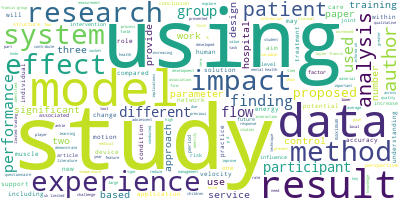

In [31]:
# Visualize the data using wordcloud package
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together
long_string = ' '.join(papers['paper_text_preprocessed'])
                       
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

#Generate a word cloud
wordcloud.generate(long_string)

#Visualize the word cloud
wordcloud.to_image()